# Daylight Saving Effect on Hypertension

In [118]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
import dowhy
from dowhy import CausalModel
import os
import cdt

from warnings import filterwarnings
filterwarnings('ignore')

from itertools import combinations
# cdt.SETTINGS.rpath = '/usr/lib/R/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:\Program Files\R\R-4.3.2\bin\Rscript' # for Windows
from numpy.random import normal
import pingouin as pg

np.random.seed(0)

# Motivation and Data Processing

Motivation, description of dataset and causal questions, description of assumptions, show true causal graph or a reasonable guess (10% grade)

The dataset we will use is the [healthcare dataset from Kaggle](https://www.kaggle.com/datasets/prasad22/healthcare-dataset). It contains 10,000 rows where each row represents a patients healthcare record. To guarantee patients' privacy and comply with healthcare regulations, no real patient information is used. Instead the data is generated based on actual healthcare records and it is made to consist of a similar structure and contain similar attributes. It seems to be oriented at healthcare records from the United States based on the generated data, although no clarity is provided regarding their sources on their Kaggle page. The dataset captures observations from individual patient healthcare records, indicating its observational nature.

The dataset includes the medical condition for which the patients are admitted to the hospital. We will focus on the hypertension condition which is an sustained increase in blood pressure. Untreated hypertension can according to the [WHO](https://www.who.int/news-room/fact-sheets/detail/hypertension), among other problems, cause heart- and vascular diseases and can lead to life threatening complications such as a heart attack or heart failure. 

Hypertension can have a variety of causes. One of which is the increase of blood pressure due to a shortage of sleep [(Palagini et al., 2013)](https://www.researchgate.net/profile/Dieter-Riemann/publication/233749083_Sleep_Loss_and_Hypertension_A_Systematic_Review/links/0fcfd50b9d9236bbfd000000/Sleep-Loss-and-Hypertension-A-Systematic-Review.pdf). This forms the basis for our causal investigation, in which we want to find if the daylight saving time (DST) in the month March (also known as "spring forward") causes more patients to be admitted for hypertension. Our reasoning is that the abrupt time change distorts the circadian rhythms of people and additionaly they could suffer from sleep due to the clock being forwarded by 1 hour. We base these assumptions on two papers in which examine the health consquences of the DST time change ([Jiddou et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0002914912024435); [Zhang et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007927&campaign_url=https%3A%2F%2Fwww.garnethealth.org%2Fnode&hgcrm_campaign_url=https%3A%2F%2Fwww.garnethealth.org%2Fnode)). Our investigation aims to examine the impact of the daylight saving time (DST) time-shift on the occurrence of hypertension in individuals.

We make several assumptions about our dataset. We assume causal sufficiency (which implies that there are no unobserved confounders between the daylight saving in march time-change and hypertension). Additionally we assume the data is represented with a DAG (so it is acyclic). Lastly we assume positivity, that every subgroup of variables is assigned samples when before (a value of 0) and after (a value if 1) daylight saving in march. The encoding of our treatment variable will be explained later in this section.



In [119]:
file_path = '../data/healthcare/healthcare_dataset.csv'
df = pd.read_csv(file_path)

In [120]:
# file_path = 'data/healthcare/healthcare_dataset.csv'
# df = pd.read_csv(file_path)

We start with an insight in the unique medical conditions in the 'Medical Condition' column and create our outcome variable 'Hypertension'. It is a one-hot encoded column containing a 1 if a patient is admitted for hypertension and 0 otherwise.

In [121]:
print(df['Medical Condition'].value_counts())

df = pd.concat([df, pd.get_dummies(df['Medical Condition'], dtype='int')], axis=1)
df = df.drop(columns='Medical Condition')
df = df.drop(columns=['Asthma', 'Cancer', 'Arthritis', 'Obesity', 'Diabetes'])
df.head()

Medical Condition
Asthma          1708
Cancer          1703
Hypertension    1688
Arthritis       1650
Obesity         1628
Diabetes        1623
Name: count, dtype: int64


,Name,Age,Gender,Blood Type,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Hypertension
0,Tiffany Ramirez,81,Female,O-,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive,0
1,Ruben Burns,35,Male,O+,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal,0
2,Chad Byrd,61,Male,B-,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal,0
3,Antonio Frederick,49,Male,B-,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal,0
4,Mrs. Brandy Flowers,51,Male,O-,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal,0


The dataset contains multiple entries with the same patient name. We only keep first entry of the same person since we do not want to include subsequent related hosipital admissions since they could span over a longer period than our specic timepoint of the DST.

In [122]:
filtered_df = df[~df['Name'].duplicated(keep='first')]
print(f'{df.shape[0] - filtered_df.shape[0]} entries are removed')

622 entries are removed


Let's see how many unique values each variable has.

In [123]:
for col_name in filtered_df.columns:
    print(f'{col_name}:{filtered_df[col_name].nunique()}')

Name:9378
Age:68
Gender:2
Blood Type:8
Date of Admission:1812
Doctor:8856
Hospital:8144
Insurance Provider:5
Billing Amount:9378
Room Number:400
Admission Type:3
Discharge Date:1832
Medication:5
Test Results:3
Hypertension:2


We decide that the following variables are irrelevant for our analysis or have arbitrary data: ```['Doctor', 'Hospital', 'Room Number', 'Discharge Date']```. We can also drop ```'Name'``` since we already filtered by the first visit of unique individuals.

In [124]:
filtered_df = filtered_df.drop(columns=['Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Name'])

Let's see the unique values of the columns with less than 10 unique values. We print the column names containing continuous data.

In [125]:
categoricals = []

for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(f'{col_name}:{filtered_df[col_name].unique()}')
        categoricals.append(col_name)
    else:
        print(f'{col_name} is a continuous variable.')

Age is a continuous variable.
Gender:['Female' 'Male']
Blood Type:['O-' 'O+' 'B-' 'AB+' 'A+' 'AB-' 'A-' 'B+']
Date of Admission is a continuous variable.
Insurance Provider:['Medicare' 'UnitedHealthcare' 'Aetna' 'Cigna' 'Blue Cross']
Billing Amount is a continuous variable.
Admission Type:['Elective' 'Emergency' 'Urgent']
Medication:['Aspirin' 'Lipitor' 'Penicillin' 'Paracetamol' 'Ibuprofen']
Test Results:['Inconclusive' 'Normal' 'Abnormal']
Hypertension:[0 1]


Let's examine the seasonal patterns in hospital admissions and compare it with the trends observed among patients diagnosed with Hypertension. This allows us to determine the range of the period in which we want to look for the effect of the DST time change.

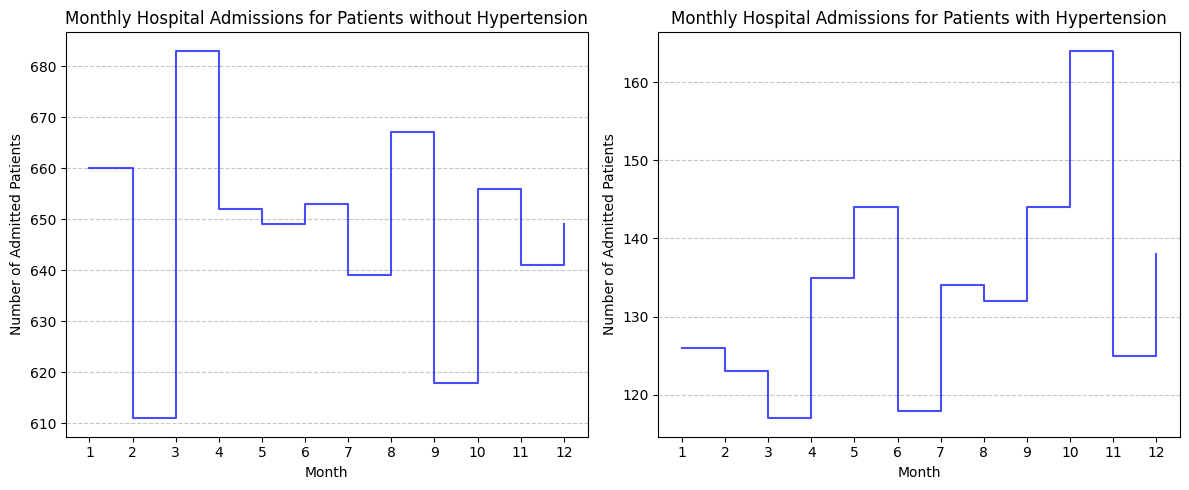

In [126]:
# Note: y-axis does not start at 0
filtered_df['Date of Admission'] = pd.to_datetime(filtered_df['Date of Admission'])
plt.figure(figsize=(12, 5))

# admitted patients without hypertension
plt.subplot(1, 2, 1)
doy_frequency = filtered_df['Date of Admission'][filtered_df.Hypertension == 0].apply(lambda x: x.month).value_counts().sort_index(ascending=True)
plt.step(doy_frequency.index, doy_frequency.values, where='post', color='blue', alpha=0.7)
plt.xticks(range(1, 13))
plt.title('Monthly Hospital Admissions for Patients without Hypertension')
plt.xlabel('Month')
plt.ylabel('Number of Admitted Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# admitted patients with hypertension
plt.subplot(1, 2, 2)
doy_frequency = filtered_df['Date of Admission'][filtered_df.Hypertension == 1].apply(lambda x: x.month).value_counts().sort_index(ascending=True)
plt.step(doy_frequency.index, doy_frequency.values, where='post', color='blue', alpha=0.7)
plt.xticks(range(1, 13))
plt.title('Monthly Hospital Admissions for Patients with Hypertension')
plt.xlabel('Month')
plt.ylabel('Number of Admitted Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


When interpreting the graphs, take note that the y-axis do not start at 0, this is done to emphasize the monthly differences.

In the graph depicting the number of patients admitted to the hospital for Hypertension, the two months following March (in which DST takes place) exhibit higher admission counts compared to the preceding months. However, when examining the admissions for other medical conditions, the month of February similarly shows significantly fewer admissions than march. 

To isolate the effect of DST on hypertension, we choose to investigate a 20-day period after DST in spring. The limits the influence of the montly fluctuations in the datset and is in line with similar papers which examine the health effects of the DST time-change. A time-period of a week in [Jiddou et al. (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0002914912024435) and 28 days in [Zhang et al. (2020)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007927&campaign_url=https%3A%2F%2Fwww.garnethealth.org%2Fnode&hgcrm_campaign_url=https%3A%2F%2Fwww.garnethealth.org%2Fnode).





To create a variable which encodes the DST change in spring, we aim to introduce a binary column: assigning a value of 1 if the admission date falls within a 10-day window surrounding the annual DST change in March (a period during which individuals typically adjust their schedules due to a one-hour reduction in sleep), and 0 otherwise. Our dataset spans the years 2018-2023, and we construct a dictionary pairing each year with the specific date of the daylight saving time transition.

In [127]:
daylight_saving_dates = {
    2018: '2018-03-25',
    2019: '2019-03-31',
    2020: '2020-03-29',
    2021: '2021-03-28',
    2022: '2022-03-27',
    2023: '2023-03-26'}

In [128]:
daylight_saving_dates = {year: pd.to_datetime(date) for year, date in daylight_saving_dates.items()}

filtered_df['Date of Admission'] = pd.to_datetime(filtered_df['Date of Admission'])

filtered_df['daylight_saving_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[date.year] <= date <= daylight_saving_dates[date.year] + pd.DateOffset(days=20)
                                                                        else 0)

filtered_df['daylight_saving_before_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[date.year] >= date >= daylight_saving_dates[date.year] - pd.DateOffset(days=20)
                                                                        else 0)

Let's see how balanced is our data.

In [129]:
for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(filtered_df[col_name].value_counts())
        print()

Gender
Female    4768
Male      4610
Name: count, dtype: int64

Blood Type
AB-    1195
B-     1187
AB+    1187
O+     1172
A-     1171
O-     1166
B+     1159
A+     1141
Name: count, dtype: int64

Insurance Provider
Cigna               1914
Aetna               1907
Blue Cross          1896
UnitedHealthcare    1852
Medicare            1809
Name: count, dtype: int64

Admission Type
Urgent       3179
Emergency    3156
Elective     3043
Name: count, dtype: int64

Medication
Penicillin     1951
Lipitor        1890
Aspirin        1849
Paracetamol    1848
Ibuprofen      1840
Name: count, dtype: int64

Test Results
Abnormal        3231
Inconclusive    3093
Normal          3054
Name: count, dtype: int64

Hypertension
0    7778
1    1600
Name: count, dtype: int64

daylight_saving_march
0    8826
1     552
Name: count, dtype: int64

daylight_saving_before_march
0    8853
1     525
Name: count, dtype: int64



# Exploratory Data Analysis

## Our estimate of the causal graph
We start with reasoning about the relevant variables and their connections to create an estimation for the causal graph afer which we will perform independence tests and correct the graph if necessary.

In [130]:
for col_name in filtered_df.columns:
    print(col_name)

Age
Gender
Blood Type
Date of Admission
Insurance Provider
Billing Amount
Admission Type
Medication
Test Results
Hypertension
daylight_saving_march
daylight_saving_before_march


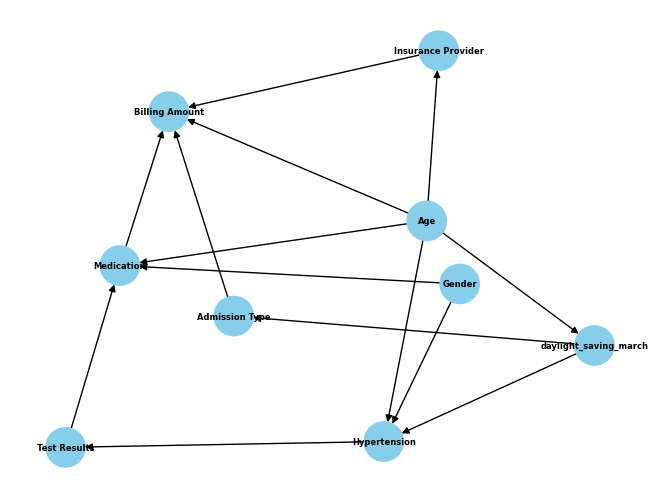

In [131]:
graph_variables = ['Age', 'Gender', 'Insurance Provider', 'Billing Amount', 
                   'Admission Type', 'Medication', 'Test Results', 'Hypertension', 'daylight_saving_march']

G = nx.DiGraph()
G.add_nodes_from(graph_variables)

edges = [
    ('Insurance Provider', 'Billing Amount'),       # Insurance Provider decides the billing amount
    ('Age', 'Billing Amount'),                      # Older people require more care for same treatment
    ('Age', 'Insurance Provider'),                  # Age focussed marketing or personal preference by age
    ('Age', 'Hypertension'),                        # Blood pressure rises with age and likelihood of hypertension 
    ('Age', 'Medication'),                          # Older people might get different medication
    ('Gender', 'Hypertension'),                     # Hormonal reasons and differences in blood pressure between men and women
    ('Gender', 'Medication'),                       # Not all medicine apply to men or women
    ('Hypertension', 'Test Results'),               # The medical condition influences the outcome of the tests           
    ('Test Results', 'Medication'),                 # Medication is prescribed based on the outcome of the tests
    ('Medication', 'Billing Amount'),               # Billing amount is dependent on the prescribed medication
    ('daylight_saving_march', 'Hypertension'),      # hypothesis: due to lack of sleep and distorted bio rhythm
    ('Admission Type', 'Billing Amount'),           # An emergency admission requires more money to e paid
    ('daylight_saving_march', 'Admission Type'),    # See explanation below
    ('Age', 'daylight_saving_march'),               # See explanation below
]


G.add_edges_from(edges)

pos = nx.kamada_kawai_layout(G)
node_size = [800 if node in graph_variables else 200 for node in G.nodes]
node_color = ['skyblue' if node in graph_variables else 'lightgray' for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_size=6, node_size=node_size, node_color=node_color, font_color='black', font_weight='bold', arrowsize=10)

plt.tight_layout()
plt.show()

In [132]:
# Check for cycles
list(nx.simple_cycles(G))

The explanations for the edges in the graph can be found in the code cell above. Two less obvious connections require additional explaining:
1. ('daylight_saving_march' -> 'Admission Type'): 'daylight_saving_march' represents a time-period for the admitted patients in which people can suffer from insufficient sleep or encounter disruptions in their sleep patterns which has impact on individuals' circadian rhythms and overall well-being which effects the requirement of a higher urgency admission.
2. ('Age' -> 'daylight_saving_march'): The average age of admitted patients fluctuates during the year due to factors (such as the seasonal wheater or hours of daylight) preventing or causing specific age groups to get admitted to the hospital. Thus, a patient's age influences whether they are admitted during this 20-day time period.

The ('Age' -> 'daylight_saving_march') arrow can be substantiated by looking at the trend of the average age of patients being admitted to the hospital for hypertension. In the plot below we see a fluctuation in the average age per month and the largest difference is April (47.64 year old) and May (53.69 year old), a difference in average age of about 7 years. 

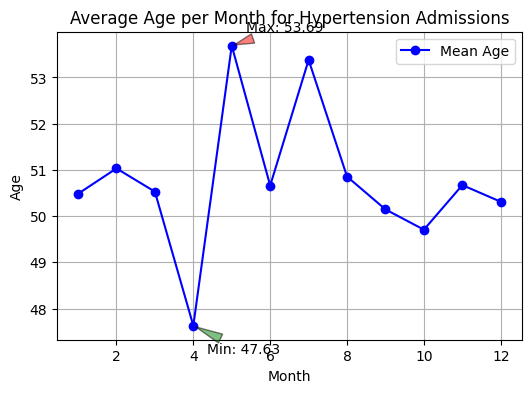

In [133]:
# create copy of dataframe for plot
agedf = filtered_df.copy()
agedf['Month'] = agedf[agedf['Hypertension']==1]['Date of Admission'].apply(lambda x: x.month)

monthly_age_stats = agedf.groupby(['Month']).agg({'Age': ['mean', 'max', 'min']})

# create plot
plt.figure(figsize=(6, 4))
plt.plot(monthly_age_stats.index, monthly_age_stats['Age']['mean'], marker='o', linestyle='-', color='b', label='Mean Age')

# annotate max and min
max_val = monthly_age_stats.loc[monthly_age_stats['Age']['mean'].idxmax()]['Age']['mean']
min_val = monthly_age_stats.loc[monthly_age_stats['Age']['mean'].idxmin()]['Age']['mean']
plt.annotate(f'Max: {max_val:.2f}', xy=(monthly_age_stats['Age']['mean'].idxmax(), max_val), xytext=(10, 10),
             textcoords='offset points', arrowprops=dict(facecolor='red', arrowstyle='wedge,tail_width=0.7', alpha=0.5))
plt.annotate(f'Min: {min_val:.2f}', xy=(monthly_age_stats['Age']['mean'].idxmin(), min_val), xytext=(10, -20),
             textcoords='offset points', arrowprops=dict(facecolor='green', arrowstyle='wedge,tail_width=0.7', alpha=0.5))

plt.title('Average Age per Month for Hypertension Admissions')
plt.xlabel('Month')
plt.ylabel('Age')
plt.grid(True)
plt.legend()
plt.show()

## Independence tests
Let's identify the correlation between the variables in the dataset.

In [134]:
from itertools import permutations
import pingouin as pg

def test_all(df, vars):
    # Marginal
    for var1, var2 in permutations(vars, 2):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
        print('{} and {}: p-value is {}'.format(var1, var2, p_val))

    # Conditional
    for var1, var2, cond in permutations(vars, 3):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        print('{} and {} given {}: p-value is {}'.format(var1, var2, cond, p_val))

In [135]:
def encode_categoricals(df):
    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()

    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = label_encoder.fit_transform(df[column])
            
    return df

In order to have the partial_corr independence test work we need to have numerical columns encoded into categorical data

In [136]:
df_encoded = encode_categoricals(filtered_df)
df_encoded

,Age,Gender,Blood Type,Date of Admission,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Hypertension,daylight_saving_march,daylight_saving_before_march
0,81,0,7,2022-11-17,3,37490.983364,0,0,1,0,0,0
1,35,1,6,2023-06-01,4,47304.064845,1,2,2,0,0,0
2,61,1,5,2019-01-09,3,36874.896997,1,2,2,0,0,0
3,49,1,5,2020-05-02,3,23303.322092,2,4,0,0,0,0
4,51,1,7,2021-07-09,4,18086.344184,2,3,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,83,1,0,2022-07-29,4,39606.840083,0,1,0,0,0,0
9996,47,0,2,2022-01-06,1,5995.717488,1,1,2,0,0,0
9997,54,1,5,2022-07-01,1,49559.202905,0,1,2,0,0,0
9998,84,1,0,2020-02-06,4,25236.344761,2,4,2,0,0,0


In [137]:
test_all(df_encoded, graph_variables)

Age and Gender: p-value is 0.5118936213292858
Age and Insurance Provider: p-value is 0.9306652789231536
Age and Billing Amount: p-value is 0.3877057990783729
Age and Admission Type: p-value is 0.5411272036726902
Age and Medication: p-value is 0.38150116377421794
Age and Test Results: p-value is 0.39086435527507524
Age and Hypertension: p-value is 0.14125179220420808
Age and daylight_saving_march: p-value is 0.8089646632771187
Gender and Age: p-value is 0.5118936213292855
Gender and Insurance Provider: p-value is 0.05167704764915206
Gender and Billing Amount: p-value is 0.639947039366182
Gender and Admission Type: p-value is 0.9020256900524015
Gender and Medication: p-value is 0.5923715947692116
Gender and Test Results: p-value is 0.4194962861873396
Gender and Hypertension: p-value is 0.31032412828410577
Gender and daylight_saving_march: p-value is 0.36376767775658936
Insurance Provider and Age: p-value is 0.9306652789231536
Insurance Provider and Gender: p-value is 0.05167704764915206


## Interpretation on results

We expect to get significant p-values for all tests where the graph implies dependece between the variables. We list below some significant conclusions on the p-value.

### Independences

From the independence tests we can notice the low p-values which are below 0.1 the following imply independence:

- gender and insurance provider on their own, but also conditioning on any variable, also accoring to the graph

Gender and Insurance Provider: p-value is 0.05167704764915217

- insurance provider and billing amount, however in the graph we decided there should be some dependence.

Insurance Provider and Billing Amount: p-value is 0.0820549226831016

- Insurance provider is also independent from gender, also according to our graph

Insurance Provider and Gender: p-value is 0.05167704764915217

- medication and daylight saving march, not according with our graph because there is a direct path between the two variables: daylight_saving_march --> Hypertension --> Test Results --> Medication

### Dependences

The high p-values show us the dependence between the variables:
- also according to our graph, there is a high dependence between insurance provider and age

Insurance Provider and Age: p-value is 0.930665278923154


- Insurance Provider and medication are dependent because they are cofounded by Age, also according to our graph

Insurance Provider and Medication: p-value is 0.6086810195977133

- Hypertension is highly dependent on Insurance Provider, also a conclusion aligning with our graph

Insurance Provider and Hypertension: p-value is 0.9939665403739955

- Tests Result is highly correlated with daylight saving, also according to our graph. Test Result seems to be dependent on all the variables, this is also reflected in the graph we came up with which seems great.

Test Results and daylight_saving_march: p-value is 0.6844684976503201

- Billing amount is dependent on gender, not accordyng to our graph.

Billing Amount and Gender: p-value is 0.6399470393661836

## Modifications of the graph after the independence tests

Given the results form the independence tests, we will make the following modifications in our graph:

- Insurance provider will not directly affect billing amount
- insurance provider directly influences hypertension, and age is a confounder for the two
- add an arrow between billing amount and gender
- we eliminate medication and test results as nodes because they might be time dependent (is the medication taken after the test results)

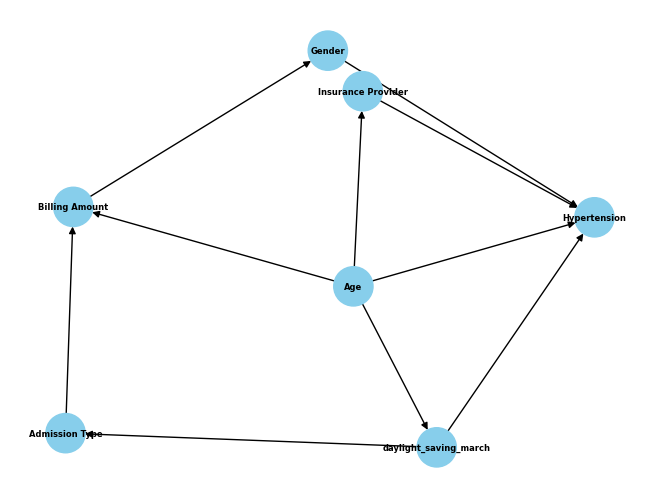

In [138]:
graph_variables = ['Age', 'Gender', 'Insurance Provider', 'Billing Amount', 
                   'Admission Type', 'Hypertension', 'daylight_saving_march']

G = nx.DiGraph()
G.add_nodes_from(graph_variables)

edges = [
    ('Age', 'Billing Amount'),                     
    ('Age', 'Insurance Provider'),                 
    ('Age', 'Hypertension'),                       
    ('Gender', 'Hypertension'),                    
    ('daylight_saving_march', 'Hypertension'),     
    ('Admission Type', 'Billing Amount'),          
    ('daylight_saving_march', 'Admission Type'),   
    ('Age', 'daylight_saving_march'),              
    ('Insurance Provider', 'Hypertension'),        
    ('Billing Amount', 'Gender')
]


G.add_edges_from(edges)

pos = nx.kamada_kawai_layout(G)
node_size = [800 if node in graph_variables else 200 for node in G.nodes]
node_color = ['skyblue' if node in graph_variables else 'lightgray' for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_size=6, node_size=node_size, node_color=node_color, font_color='black', font_weight='bold', arrowsize=10)
nx.write_gml(G, "causal_graph.gml")

plt.tight_layout()
plt.show()

In [139]:
# Check for cycles
list(nx.simple_cycles(G))

## Exploring the hypertension admission frequencies surrounding DST time-change

Before continuing with the causal analysis, lets consider the statstics for patients with hypertension before and after the DST time change.

In [140]:
# AFTER daylight saving time (from last sunday of march)
n_hyp = filtered_df[filtered_df.Hypertension == 1].shape[0]
n_hyp_after = filtered_df[filtered_df.Hypertension == 1][filtered_df['daylight_saving_march'] == 1].shape[0]
perc_hyp_after = (n_hyp_after / n_hyp)*100

n_after_march = filtered_df[filtered_df['daylight_saving_march'] == 1].shape[0]
perc_hyp_after_total = (n_hyp_after / n_after_march) * 100
print(f'Of the {round(n_hyp, 2)} admissions for hypertension, {round(perc_hyp_after, 2)} percent was in the 20-days AFTER daylight saving in march')
print(f'This formed {round(perc_hyp_after_total, 2)} percent of the total of {round(n_after_march, 2)} admissions for any condition in the same time period')

Of the 1600 admissions for hypertension, 5.69 percent was in the 20-days AFTER daylight saving in march
This formed 16.49 percent of the total of 552 admissions for any condition in the same time period


In [141]:
# BEFORE daylight saving march
n_hyp_before = filtered_df[filtered_df.Hypertension == 1][filtered_df['daylight_saving_before_march'] == 1].shape[0]
perc_hyp_before = (n_hyp_before / n_hyp)*100

n_before_march = filtered_df[filtered_df['daylight_saving_before_march'] == 1].shape[0]
perc_hyp_before_total = (n_hyp_before / n_before_march) * 100
print(f'Of the {round(n_hyp, 2)} admissions for hypertension {round(perc_hyp_before, 2)} percent was in the 20-days BEFORE daylight saving in march')
print(f'This formed {round(perc_hyp_before_total, 2)} percent of the total of {round(n_before_march, 2)} admissions for any condition in the same time period')

Of the 1600 admissions for hypertension 5.06 percent was in the 20-days BEFORE daylight saving in march
This formed 15.43 percent of the total of 525 admissions for any condition in the same time period


We notice that 5.69% of Hypertension cases happen within 20 days after the daylight saving in March, while 5.06% of the hypertension cases happen before the daylight saving time. 

From the plot with the patients admitted per month showed that there is a deviation from month to month in the number of admissions. Therefore we also need to look at the proportion of hypertension cases compared to the total hospital admissions.

We see that the proportion of Hypertension cases among all hospital admissions is also greater in the 20 days following the DST time change compared to 20 days preceding the time change. This is in line with our hypothesis.

# Identify estimands for backdoor, frontdoor criterion and IVs

### Finding all paths between ```daylight_saving_march``` and ```Hypertension```

Number of paths found: 7


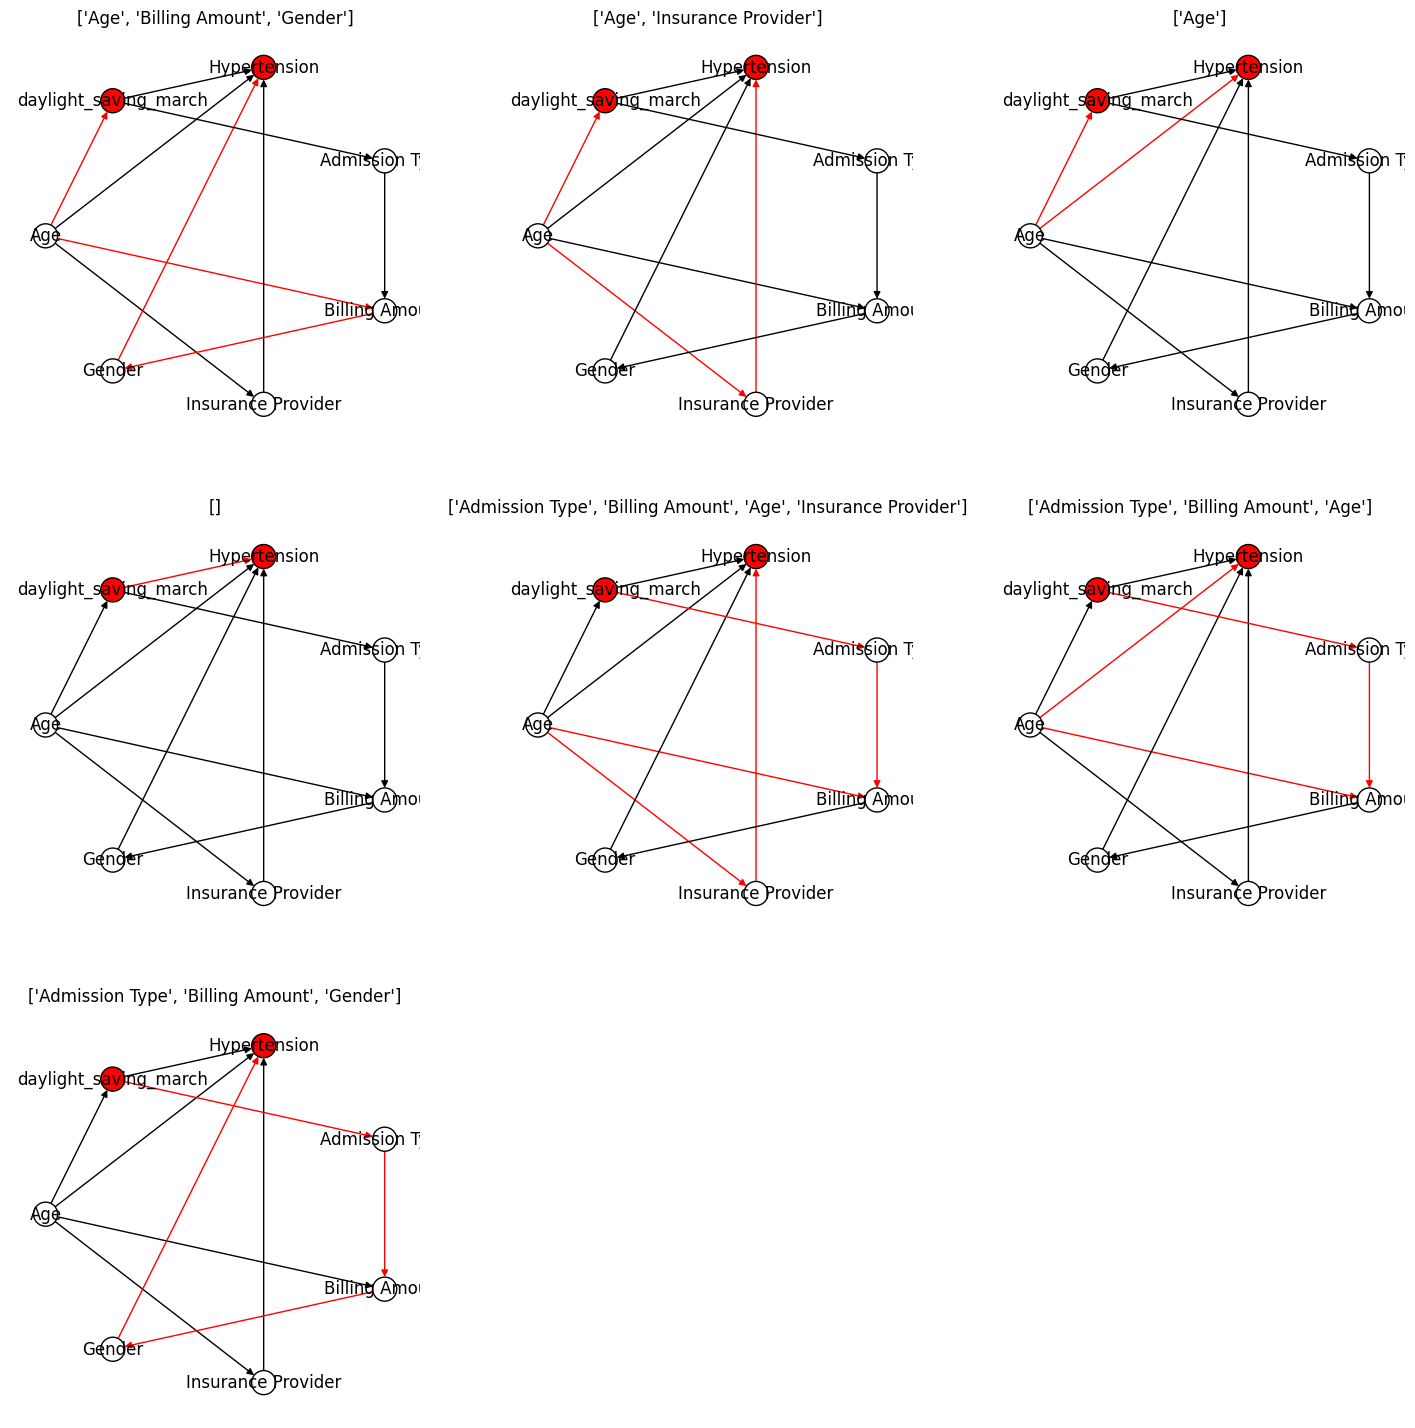

In [142]:
all_paths = list(nx.all_simple_paths(G.to_undirected(), source='daylight_saving_march', target='Hypertension'))
print('Number of paths found:', len(all_paths))

if len(all_paths) > 20:
    all_paths = all_paths[:20]
    
n_cols = 3
n_rows = (len(all_paths) - 1) // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 6 * n_rows))

for i, path in enumerate(all_paths):
    col = i % n_cols
    row = i // n_cols
    edges_on_path = [set([source, target]) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if set(edge) in edges_on_path else 'black' for edge in G.edges()]  
    nx.draw_shell(G, with_labels=True, node_color=['w' if i < len(graph_variables) - 2 else 'r' for i in range(len(graph_variables))], edgecolors='black', ax=axs[row, col], edge_color=edge_color)
    axs[row, col].set_title(path[1:-1])
    
# hide empty plots
for i in range(len(all_paths), n_rows * n_cols):
    axs.flatten()[i].axis('off')

Daylight_saving_march and Hypertension are not d-separated because they have a direct connection.

### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from ```daylight_saving_march``` and ```Hypertension```. We can apply the backdoor criterion here because there are arrows that go into our treatment, ```daylight_saving_march```, and many confounders on the way for which we need to adjust.


INFO:dowhy.causal_model:Model to find the causal effect of treatment ['daylight_saving_march'] on outcome ['Hypertension']
INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


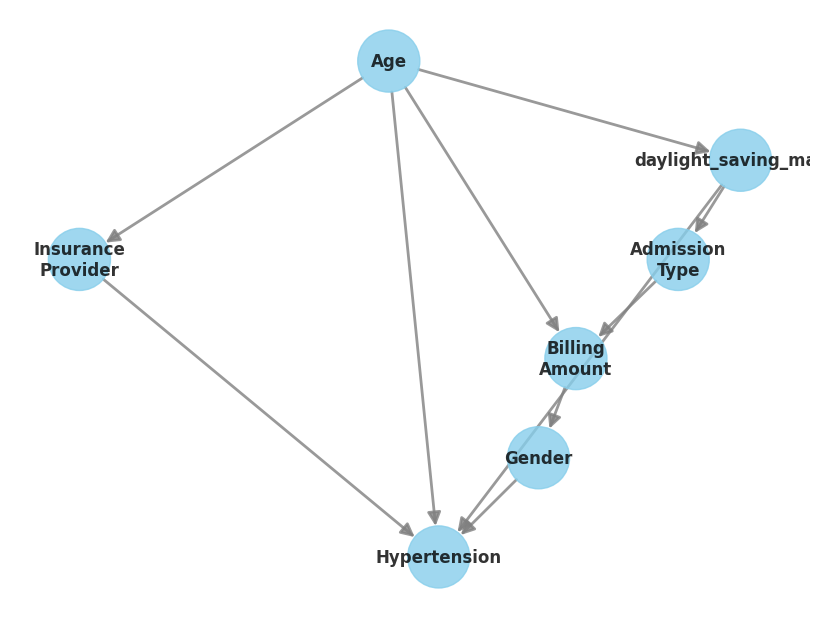

In [143]:
from dowhy import CausalModel

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('causal_graph.gml')
# With GML string
model=CausalModel(
    data = df_encoded,
    treatment='daylight_saving_march', 
    outcome='Hypertension',
    graph=gml_graph
)
model.view_model()

In [144]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

df_encoded.head()

# creating a copy of our graph G that is undirected
H = G.to_undirected()
# all_possible_paths = list(nx.all_simple_paths(H, 'daylight_saving_march', 'Hypertension'))
bd = backdoor.Backdoor(G, 'daylight_saving_march','Hypertension')
backdoor_paths = [path for path in all_paths if bd.is_backdoor(path)]

#### Visualization of backdoor paths

Number of backdoor paths found: 3


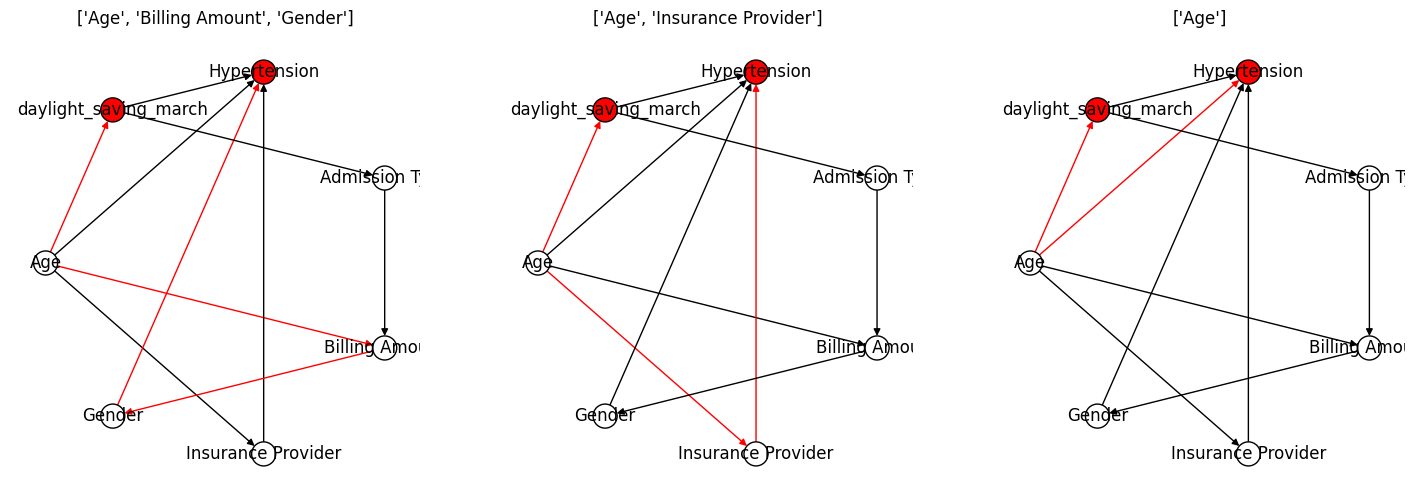

In [145]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path

print('Number of backdoor paths found:', len(backdoor_paths))

if len(backdoor_paths) > 20:
    backdoor_paths = backdoor_paths[:20]
    
n_cols = 3
n_rows = (len(backdoor_paths) - 1) // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 6 * n_rows))

for i, path in enumerate(backdoor_paths):
    col = i % n_cols
    row = i // n_cols
    edges_on_path = [set([source, target]) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if set(edge) in edges_on_path else 'black' for edge in G.edges()]  
    nx.draw_shell(G, with_labels=True, node_color=['w' if i < len(graph_variables) - 2 else 'r' for i in range(len(graph_variables))], edgecolors='black', ax=axs[col], edge_color=edge_color)
    axs[col].set_title(path[1:-1])
    
# hide empty plots
for i in range(len(backdoor_paths), n_rows * n_cols):
    axs.flatten()[i].axis('off')

We find three backdoor paths between our treatment and the outcome. Let's analyse what we need to adjust for.

In [146]:
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

In [147]:
for path in backdoor_paths:
    colliders = np.array([])
    non_colliders = []
    path_len = len(path)

    # we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
    for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
        # if there is an arrow pointing into node1 from both sides on the path, it is a collider
        if G.has_edge(node0, node1) and G.has_edge(node2, node1):
            colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
    # we flatten the list of list
    colliders = colliders.flatten()

    # any node on the path (excluding the source and target) that is not a collider is a non-collider
    non_colliders = [x for x in path[1:-1] if x not in colliders]

    # finally, we add the information to our dataframe, with the path, colliders, and non-colliders
    adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

In [148]:
adjustment_variables

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Billing Amount, G...",[],"[Age, Billing Amount, Gender]"
1,"[daylight_saving_march, Age, Insurance Provide...",[],"[Age, Insurance Provider]"
2,"[daylight_saving_march, Age, Hypertension]",[],[Age]


There are no colliders on any of the backdoor paths. We need to condition on at least one common non-collider from the three paths found, which are not in the collider set. Therefore, we need to condition on ```Age``` to block all backdoor paths from our treatment ```daylight_saving_march``` to our outcome ```Hypertension```.

### Frontdoor Criterion

We want to also apply the frontdoor criterion. We want to find the adjustment set which satisfies the frontdoor criterion. First of all we need to get all directed paths from ```daylight_saving_march``` and ```Hypertension```.

In [149]:
our_causal_graph = model._graph
our_causal_graph.get_all_directed_paths(["daylight_saving_march"], ["Hypertension"])

[['daylight_saving_march', 'Hypertension'],
 ['daylight_saving_march',
  'Admission Type',
  'Billing Amount',
  'Gender',
  'Hypertension']]

Because there is a direct edge between our treatment and our outcome, we cannot apply the frontdoor criterion. The adjustment set able to satiisfy this criterion needs to intercent all directed patch from ```daylight_saving_march``` and ```Hypertension``` and because of the direct edge between the two variables, such an adjustment set does not exist.

### Instrumental Variables

We believe there is an unobserved confounder, ```sleep_quality```, between ```daylight_saving_march``` and ```Hypertension``` because one less hour of sleep could directly affect the hypertension risks and the date of admission to the hospital.

The only measure that we have which could influece the date of admission (implicitly ```daylight_saving_march```) is ```Age```. Depending on age, people have different routines during the year, moments where stress is higher, or they simply have a higher risk of getting a heart attack.

However, ```Age``` cannot be part of the adjustment set for the Instrumental Variables criterion because it has a direct effect on ```Hypertension```. Therefore, there are no variables found to adjust for the iv.

### DoWhy Check

In [150]:
identified_estimand = model.identify_effect()
print(identified_estimand)

identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



[{'backdoor_set': ('Age', 'Insurance Provider')}, {'backdoor_set': ('Age',)}]

Indeed, we need to adjust for ```Age``` to block all the backdoor paths. There is no adjustment set found for the frontdoor criterion or the instrumental variables criterion.

# Estimate the causal effects

Given our reasoning from the previous section, we know that we have to condition on ```Age``` to get the true effect of ```daylight_saving_march``` on ```Hypertension```. We apply different estimators from the DoWhy package.

#### Linear Estimator

In [151]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age+daylight_saving_march*Insurance Provider


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age+daylight_saving_march*Insurance Provider
Target units: ate

## Estimate
Mean value: -0.006346644964427245

Causal Estimate is -0.006346644964427245


In [152]:
# Textual Interpreter
causal_estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [daylight_saving_march] from 0 to 1 causes an increase of -0.006346644964427245 in the expected value of the outcome [['Hypertension']], over the data distribution/population represented by the dataset.


With a linear estimator we have a causal effect of -0.02849093. We can see that maybe a linear estimator is not the best to apply. We might think that the true nature of our effect and the assumptions made by the estimator do not match entirely. We would expect for a positive causal estimate effect of the ```daylight_saving_march``` and ```Hypertension```. We therefore apply one more estimate

#### Propensity Score Stratification

In [153]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_model:propensity_score_stratification
INFO:dowhy.causal_estimator:Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age
INFO:dowhy.causal_estimator:'num_strata' selected as 468.9
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 234
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 117
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 58
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 29


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age
Target units: att

## Estimate
Mean value: -0.005214838653679407

Causal Estimate is -0.005214838653679407


In [154]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [daylight_saving_march] from 0 to 1 causes an increase of -0.005214838653679407 in the expected value of the outcome [['Hypertension']], over the data distribution/population represented by the dataset.


#### Propensity Score Matching

In [155]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_model:propensity_score_matching
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age
Target units: atc

## Estimate
Mean value: 0.034783593927033764

Causal Estimate is 0.034783593927033764


In [156]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [daylight_saving_march] from 0 to 1 causes an increase of 0.034783593927033764 in the expected value of the outcome [['Hypertension']], over the data distribution/population represented by the dataset.


We notice that we finally get a positive effect of the ```daylight_saving_march``` on ```Hypertension``` when using a propensity score matching. Weirdly enough, when the data is stratified and using a propensity score we get a causal effect of -0.028. When match units in data instead we obtain a positive causal effect 0.00461.

# Finding the Causal Graph with Causal Discovery

#### Obtain skeleton of graph

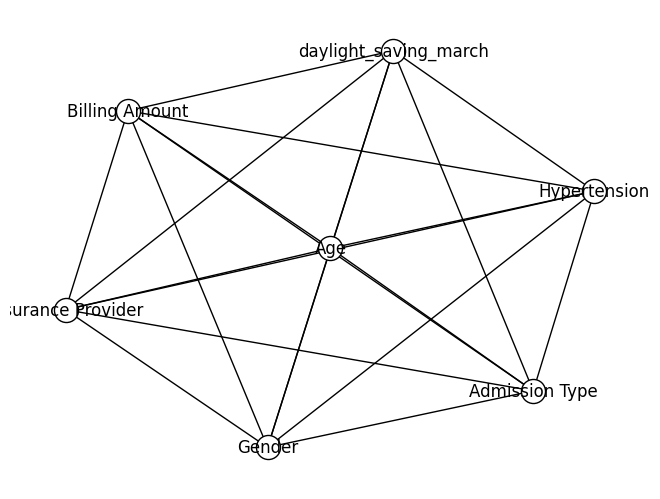

In [157]:
nodes =  graph_variables
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))

nx.draw(skeleton, with_labels=True, node_color='w', edgecolors ='black')

#### Apply independence tests to get the undirected graph

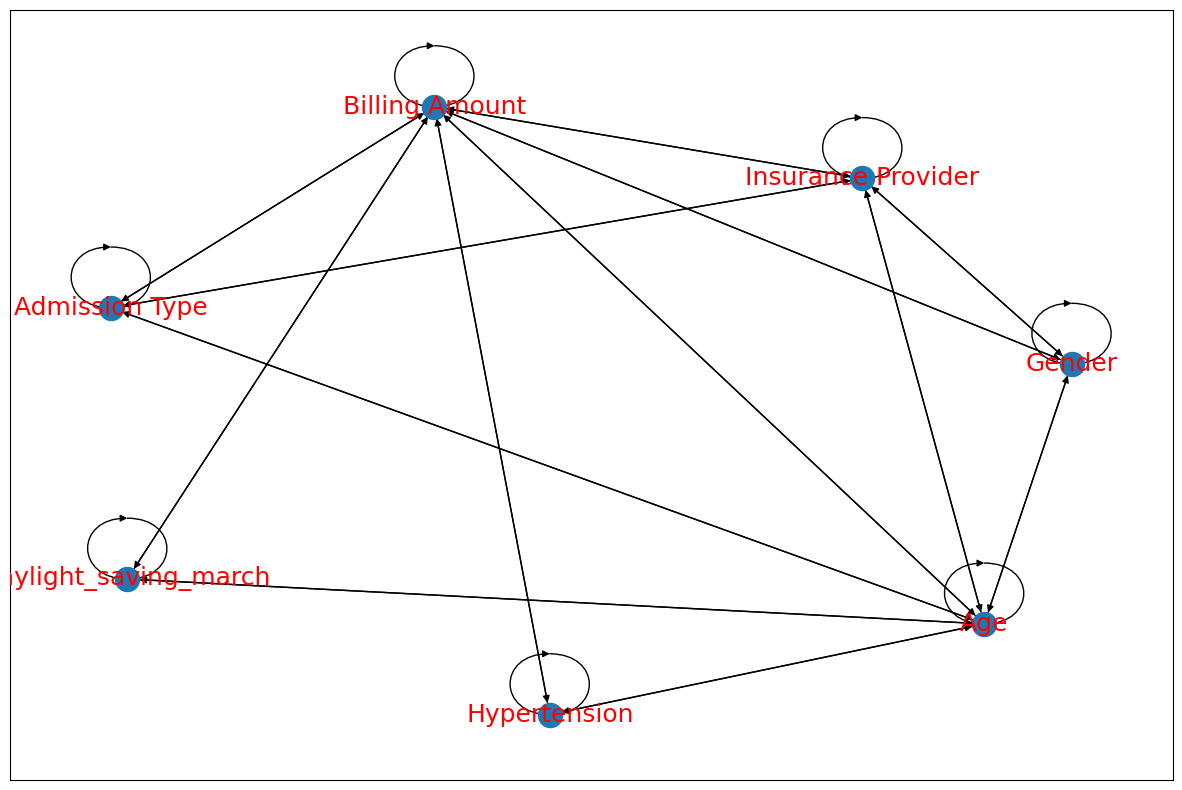

In [158]:
# initialize graph lasso
import cdt

glasso = cdt.independence.graph.Glasso()

# apply graph lasso to data
df = df_encoded[graph_variables]
skeleton = glasso.predict(df) # visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

#### Apply PC

We apply PC with ```alpha = [0.01, 0.1, 0.3]``` based on the independence tests we had in one of the previous section where most of the independent variables had a low p-value lower than 0.1. However, 0.1 and 0.3 can also be considered low values.

In [159]:
import cdt
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.01)

pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

ImportError: R Package (k)pcalg/RCIT is not available. RCIT has to be installed from https://github.com/Diviyan-Kalainathan/RCIT

In [ ]:
pc_graph.edges()

In [ ]:
import cdt
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.1)

pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

In [ ]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.3)

pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

In [ ]:
new_skeleton = cdt.utils.graph.remove_indirect_links(skeleton, alg='aracne')
model = cdt.causality.graph.GES()
output_graph = model.predict(df, new_skeleton)
print(nx.adjacency_matrix(output_graph).todense())

nx.draw(output_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

Even though we change the values of alpha, we get very bad graph results.

# Solution: using synthetic data based on our prior

As we could not find many causal relations and aim to show our implementation of our algorithms further, we simulate data that resembles our real data.
<!-- In this case we use less edges. The simulation of synthetic data is a common practise. Real data might be hard to obtain, or due to confidentiality issues it might be hard to get acces to. Privacy especially important in the case of medical data. 

It is hypothesised that the alteration in time at DST notably affects our sleep patterns. Studies indicate that following the spring time adjustment, more people encounter reduced sleep duration and an increase in disturbances in their sleep cycle. Such disruptions of sleep can lead to elevated heart rate, increased blood pressure, and a heightened risk of arrhythmias.

For illustration we add the mediator "Sleep Quality" between 'daylight_saving_march' and 'hypertension.  -->
We believe that the reason why causal discovery does not work is that the data is not Gaussian. Therefore we want to simulate our own data, corresponding to our graph.

$$
\begin{aligned}
AGE: X_1 &\leftarrow \epsilon_1 & \epsilon_1 &\sim \mathcal N(0,1)\\ 
INSURANCE PROVIDER: X_2 &\leftarrow X_1 + \epsilon_2 & \epsilon_2 &\sim \mathcal N(0,0.7)\\
ADMISSION TYPE: X_3 &\leftarrow X_7 + \epsilon_3 & \epsilon_3 &\sim \mathcal N(0,1)\\
GENDER: X_4 &\leftarrow X_6 + \epsilon_4 & \epsilon_4 &\sim \mathcal N(0,1)\\
HYPERTENSION: X_5 &\leftarrow X_7 + X_4 + X_1 + X_2 + \epsilon_5 & \epsilon_5 &\sim \mathcal N(0,1)\\
BILLING AMOUNT: X_6 &\leftarrow X_1 + X_3 + \epsilon_6 & \epsilon_6 &\sim \mathcal N(0,1.5)\\
DAYLIGHT SAVING MARCH: X_7 &\leftarrow X_1 + \epsilon_7 & \epsilon_7 &\sim \mathcal N(0,1)\\
\end{aligned}
$$

In [ ]:
n_samples=10000

eps1 = normal(0, 1, n_samples)
eps2 = normal(0, 0.7, n_samples)
eps3 = normal(0, 1, n_samples)
eps4 = normal(0, 1, n_samples)
eps5 = normal(0, 1, n_samples)
eps6 = normal(0, 1.5, n_samples)
eps7 = normal(0, 1, n_samples)

X1 = eps1
X2 = X1 + eps2
X7= X1 + eps7
X3 = X7 + eps3
X6 = X1 + X3 + eps6
X4 = X6 + eps4
X5 = X7 + X4 + X1 + X2 + eps5

# we can plot scatter plots between any two variables to test for correlation
plt.scatter(X1, X2)

In [ ]:
plt.scatter(X4, X7) # another correlation test

In [ ]:
pos = nx.kamada_kawai_layout(G)
node_size = [800 if node in graph_variables else 200 for node in G.nodes]
node_color = ['skyblue' if node in graph_variables else 'lightgray' for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_size=6, node_size=node_size, node_color=node_color, font_color='black', font_weight='bold', arrowsize=10)
nx.write_gml(G, "causal_graph.gml")

plt.tight_layout()
plt.show()

In [ ]:
from GENCDA.data_generation.relatedDataframe import RelatedDataframe
from GENCDA.data_generation.randomDataframe import randomDataframe

num_samples = 1500
# Define a DAG
graph_variables = ['Age', 'Gender', 'Insurance Provider', 'Billing Amount', 
                   'Admission Type', 'Hypertension', 'daylight_saving_march']

edges = [
    ('Age', 'Billing Amount'),                      
    ('Age', 'Insurance Provider'),                 
    ('Age', 'Hypertension'),                        
    ('Gender', 'Hypertension'),                     
    ('daylight_saving_march', 'Hypertension'),     
    ('Admission Type', 'Billing Amount'),          
    ('daylight_saving_march', 'Admission Type'),   
    ('Age', 'daylight_saving_march'),            
    ('Insurance Provider', 'Hypertension'),
    ('Billing Amount', 'Gender')
]

dag = nx.to_networkx_graph(edges, create_using=nx.DiGraph)

In [ ]:
new_synthetic_df = pd.DataFrame({'Age': X1,'Insurance Provider': X2,'Admission Type': X3,'Gender': X4,'Hypertension': X5, 'Billing Amount': X6,'daylight_saving_march': X7})
new_synthetic_df.head()

#### Apply GES algorithm

In [ ]:
# testing the GES on the newly generated syntehtic data
new_skeleton = cdt.utils.graph.remove_indirect_links(skeleton, alg='aracne')
model = cdt.causality.graph.GES()
output_graph = model.predict(new_synthetic_df, new_skeleton)

print(nx.adjacency_matrix(output_graph).todense())

nx.draw(output_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black')

#### Apply PC algorithm

In [ ]:
# testing the PC on the newly generated syntehtic data
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.01)

pc_graph = pc.create_graph_from_data(new_synthetic_df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black')

#### Apply LINGAM algorithm

In [ ]:
from cdt.causality.graph import LiNGAM

obj = LiNGAM()
output = obj.predict(new_synthetic_df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(output, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

In [ ]:
for edge in output.edges():
    print(edge)

#### Apply GIES algorithm

In [ ]:
# GIES
from cdt.causality.graph import GIES

obj = GIES()

output = obj.predict(new_synthetic_df, dag)

nx.draw_networkx(output, font_size=8)
plt.show()

We obtain the best results when using PC algorithm. Be believe this happens because the data is gaussian. We almost reconstruct the original graph perfetly in fact. A score based method does not lead to very good results because. Most of the times the resulted graph is one where hypertension causes the daylight saving. Therefore, a constraint based algorithm works best in our case.

# Conclusion

We test how the daylight saving from March (when usually people's routine starts one hour earlier) has an effect on them being admitted to hospitals with a  hypertension diagnosis. We use a dataset from Kaggle containing synthetic data generated from a true distribution of such admissions. We conduct some data preprocessing where we remove some columns, where we encode the categorical values in numerical ones to be able to apply statistical tests. Be observe some dependencies and independencies in the data and therefore we come up with a graph and assumptions, such as:
- age has an influence on the billing amount and insurance provider.

From the independence test we find a surprising conclusion:
- gender is cause by billing amount
Maybe based on how much people's treatment costs gender can be identified.

We identify the backdoor paths and conclude that we have to condition on Age in order to get the true causal effect of the daylight saving on people admitted with hypertension. We motivate why there are no frontdoor paths between the treatment and outcome and why instrumental variables cannot be used in our case given our available data.

We use a matching propensity score to obtain a very slight positive effect that daylight saving march has on hypertension. We believe that the poor results from the causal estimands is due to the complex nature of our data and the assumptions the estimators make.

Up until now we treated our analysis as if the graph was given. We apply causal discovery to our data to learn the causal graph. Unfortunately, the causal discovery techniques did not work on our data very well. We believe this is because our data does not have a Gaussian distribution. As future work, we could try and force our data to be Gaussian, or identify the distribution of our data to find better causal graphs. To prove our point, we generate some data according to the true graph and we apply causal discovery algorithms, both constraint-based and score-based.

Generally, we believe this is a great starting point for investigating if the nature of our data to construct better results for our hypothesis. We did find surprising dependence relations in the data, but at other times common knowledge could be mapped with the graph.

In conclusion, there is a very slight chance that the daylight saving in march has an effect on hypertension given the data we analysed. Maybe applying the same reasoning to other data could help get more generalized results.